1. Compute Cushion --> cushion = Asset value - floor value
2. Compute an allocation to safe and risky assets --> m * risk_budget
3. Recompute the asset value based on the returns

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import pandas as pd
import risk_kit as rk
import numpy as np



In [5]:
ind_return = rk.get_ind_returns()
tmi_return = rk.get_total_market_index_returns()

In [6]:
risky_rets = ind_return["2000":][["Steel", "Fin", "Beer"]]

# shape safe asset rets to match risky_rets 
safe_rets = pd.DataFrame().reindex_like(risky_rets)

In [12]:
safe_rets[:] = 0.03/12 # 3% per year (monthly returns)
start_amount = 1000
floor = 0.8 # 80% of start amount

In [16]:
dates = risky_rets.index
n_steps = len(dates)
account_value = start_amount
floor_value = start_amount * floor
m = 3 # multiplier

account_history = pd.DataFrame().reindex_like(risky_rets)
cushion_history = pd.DataFrame().reindex_like(risky_rets)
risky_weight_history = pd.DataFrame().reindex_like(risky_rets)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_weight = m * cushion
    risky_weight = np.minimum(risky_weight, 1)  # lower than 100%
    risky_weight = np.maximum(risky_weight, 0)  # higher than 0%
    safe_weight = 1 - risky_weight
    
    risky_alloc = account_value * risky_weight
    safe_alloc = account_value * safe_weight
    
    #update account value for the actual allocation
    account_value = (risky_alloc * (1 + risky_rets.iloc[step])) + (safe_alloc * (1 + safe_rets.iloc[step]))
    
    cushion_history.iloc[step] = cushion
    risky_weight_history.iloc[step] = risky_weight
    account_history.iloc[step] = account_value

<AxesSubplot:>

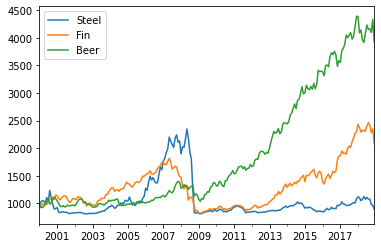

In [17]:
account_history.plot()

<AxesSubplot:>

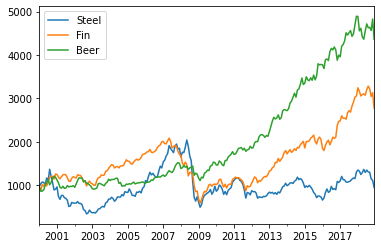

In [21]:
risky_wealth = start_amount*(1+risky_rets).cumprod()  # 100% on risky asset
risky_wealth.plot()

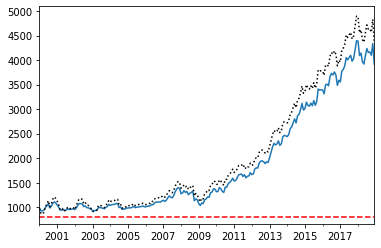

In [26]:
ax = account_history["Beer"].plot()
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(floor_value, color="r", linestyle="--")

<AxesSubplot:>

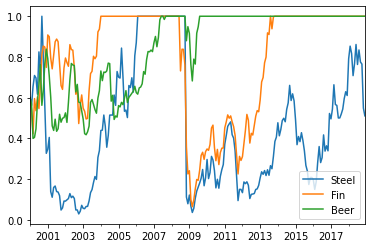

In [27]:
risky_weight_history.plot()

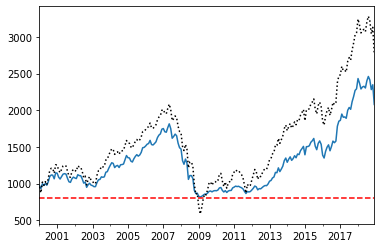

In [28]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(floor_value, color="r", linestyle="--")

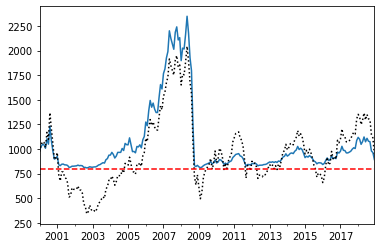

In [29]:
ind = "Steel"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(floor_value, color="r", linestyle="--")

In [30]:
rk.summary_stats(risky_rets)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [33]:
btr = rk.run_cppi(risky_rets)
rk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot:>

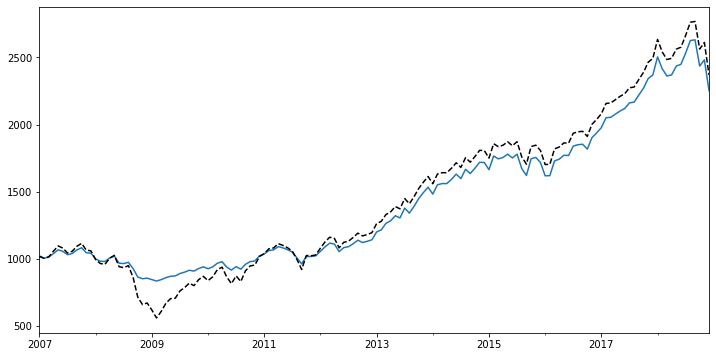

In [34]:
btr = rk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(12, 6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [36]:
rk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [37]:
rk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


<AxesSubplot:>

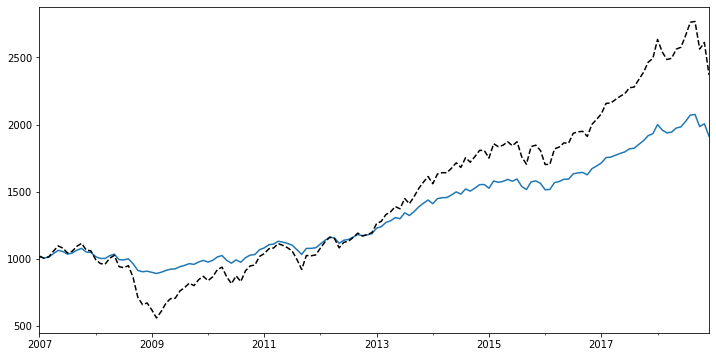

In [42]:
btr = rk.run_cppi(tmi_return["2007":], drawdown=0.2)
ax = btr["Wealth"].plot(figsize=(12, 6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)